In [1]:
import polars as pl
import os

# Path to curated panel file
curated_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_with_margins.parquet")

# Load the curated panel
panel = pl.read_parquet(curated_path)
print(f"Loaded panel shape: {panel.shape}")
#panel.head()

Loaded panel shape: (1285104, 62)


In [2]:
# Explore the column names to find turnover and sales revenue
print("Column names containing 'turnover' or 'sales':")
turnover_cols = [col for col in panel.columns if 'turnover' in col.lower()]
sales_cols = [col for col in panel.columns if 'sales' in col.lower()]

print(f"Turnover columns: {turnover_cols}")
print(f"Sales columns: {sales_cols}")

# Show all columns for context
print(f"\nAll columns ({len(panel.columns)}):")
for i, col in enumerate(panel.columns):
    print(f"{i+1:2d}. {col}")

Column names containing 'turnover' or 'sales':
Turnover columns: ['turnover', 'turnover_cat', 'asset_turnover_cal']
Sales columns: ['sales_revenue']

All columns (62):
 1. ico
 2. year
 3. other_liabilities
 4. costs
 5. sales_revenue
 6. equity
 7. profit_net
 8. turnover
 9. current_assets
10. oper_profit
11. total_liabilities
12. debt
13. total_assets
14. profit_pre_tax
15. other_assets
16. fixed_assets
17. name
18. main_nace
19. main_nace_code
20. sub_nace_cz
21. sub_nace_cz_code
22. main_okec
23. main_okec_code
24. sub_okec
25. sub_okec_code
26. esa2010
27. esa95
28. locality
29. region
30. num_employees
31. num_employees_cat
32. turnover_cat
33. audit
34. consolidation
35. currency
36. date_founded
37. date_dissolved
38. status
39. legal_form
40. entity_type
41. year_founded
42. year_dissolved
43. is_dissolved
44. operating_margin_cal
45. net_margin_cal
46. gross_margin_cal
47. roa_ebit_cal
48. roe_cal
49. roic_simple_cal
50. debt_asset_ratio_cal
51. debt_equity_ratio_cal
52. equ

In [3]:
# Focus on the specific columns we're interested in
target_cols = ['turnover', 'sales_revenue']

print("Checking if target columns exist:")
for col in target_cols:
    exists = col in panel.columns
    print(f"- {col}: {'✓' if exists else '✗'}")

if all(col in panel.columns for col in target_cols):
    print(f"\nBoth columns found! Let's analyze them.")
    
    # Basic info about these columns
    subset = panel.select(['turnover', 'sales_revenue'])
    print(f"\nDataset shape for analysis: {subset.shape}")
    print(f"\nColumn data types:")
    print(subset.dtypes)
else:
    print(f"\nSome columns missing. Let's search for similar column names:")
    relevant_cols = [col for col in panel.columns if any(term in col.lower() for term in ['turnover', 'sales', 'revenue', 'obrat', 'tržby', 'výnosy', 'výkony'])]
    print(f"Potentially relevant columns: {relevant_cols}")

Checking if target columns exist:
- turnover: ✓
- sales_revenue: ✓

Both columns found! Let's analyze them.

Dataset shape for analysis: (1285104, 2)

Column data types:
[Float64, Float64]


In [4]:
# Analyze data availability patterns
import numpy as np

# Create a subset with the relevant columns
analysis_df = panel.select(['turnover', 'sales_revenue'])

# Check for null values
turnover_null = analysis_df['turnover'].is_null()
sales_revenue_null = analysis_df['sales_revenue'].is_null()

# Calculate availability patterns
both_available = (~turnover_null) & (~sales_revenue_null)
only_turnover = (~turnover_null) & sales_revenue_null
only_sales_revenue = turnover_null & (~sales_revenue_null)
neither_available = turnover_null & sales_revenue_null

# Count each pattern
total_records = len(analysis_df)
both_count = both_available.sum()
only_turnover_count = only_turnover.sum()
only_sales_revenue_count = only_sales_revenue.sum()
neither_count = neither_available.sum()

print("=== DATA AVAILABILITY ANALYSIS ===")
print(f"Total records: {total_records:,}")
print()
print("Availability patterns:")
print(f"1. Both available:           {both_count:8,} ({both_count/total_records*100:.1f}%)")
print(f"2. Only turnover:            {only_turnover_count:8,} ({only_turnover_count/total_records*100:.1f}%)")
print(f"3. Only sales_revenue:       {only_sales_revenue_count:8,} ({only_sales_revenue_count/total_records*100:.1f}%)")
print(f"4. Neither available:        {neither_count:8,} ({neither_count/total_records*100:.1f}%)")
print()
print("Verification:")
print(f"Sum: {both_count + only_turnover_count + only_sales_revenue_count + neither_count:,} (should equal {total_records:,})")

# Summary for logic decision
at_least_one_available = both_count + only_turnover_count + only_sales_revenue_count
print(f"\nAt least one metric available: {at_least_one_available:,} ({at_least_one_available/total_records*100:.1f}%)")

=== DATA AVAILABILITY ANALYSIS ===
Total records: 1,285,104

Availability patterns:
1. Both available:            618,729 (48.1%)
2. Only turnover:               3,380 (0.3%)
3. Only sales_revenue:            263 (0.0%)
4. Neither available:         662,732 (51.6%)

Verification:
Sum: 1,285,104 (should equal 1,285,104)

At least one metric available: 622,372 (48.4%)


In [5]:
# Analyze differences when both values are available
import matplotlib.pyplot as plt

# Filter to cases where both are available
both_available_filter = (~analysis_df['turnover'].is_null()) & (~analysis_df['sales_revenue'].is_null())
both_data = analysis_df.filter(both_available_filter)

print("=== ANALYSIS OF DIFFERENCES (when both available) ===")
print(f"Records with both values: {len(both_data):,}")

# Extract values for analysis
turnover_vals = both_data['turnover'].to_numpy()
sales_revenue_vals = both_data['sales_revenue'].to_numpy()

# Calculate differences
absolute_diff = turnover_vals - sales_revenue_vals
relative_diff = (turnover_vals - sales_revenue_vals) / sales_revenue_vals * 100  # Percentage difference

# Remove infinite/NaN values for relative difference calculation
finite_mask = np.isfinite(relative_diff) & (sales_revenue_vals != 0)
relative_diff_clean = relative_diff[finite_mask]

print("\n--- Basic Statistics ---")
print(f"Turnover - Mean: {np.mean(turnover_vals):,.0f}, Median: {np.median(turnover_vals):,.0f}")
print(f"Sales Revenue - Mean: {np.mean(sales_revenue_vals):,.0f}, Median: {np.median(sales_revenue_vals):,.0f}")

print("\n--- Absolute Differences ---")
print(f"Mean difference (turnover - sales_revenue): {np.mean(absolute_diff):,.0f}")
print(f"Median difference: {np.median(absolute_diff):,.0f}")
print(f"Std dev of differences: {np.std(absolute_diff):,.0f}")

print("\n--- Relative Differences (%) ---")
print(f"Mean relative difference: {np.mean(relative_diff_clean):.1f}%")
print(f"Median relative difference: {np.median(relative_diff_clean):.1f}%")
print(f"Std dev of relative differences: {np.std(relative_diff_clean):.1f}%")

# Check how often they are exactly equal
exactly_equal = np.sum(turnover_vals == sales_revenue_vals)
print(f"\n--- Equality Check ---")
print(f"Exactly equal values: {exactly_equal:,} ({exactly_equal/len(both_data)*100:.1f}%)")

# Check ranges of relative differences
print(f"\n--- Distribution of Relative Differences ---")
within_1pct = np.sum(np.abs(relative_diff_clean) <= 1)
within_5pct = np.sum(np.abs(relative_diff_clean) <= 5)
within_10pct = np.sum(np.abs(relative_diff_clean) <= 10)
total_valid = len(relative_diff_clean)

print(f"Within ±1%:  {within_1pct:,} ({within_1pct/total_valid*100:.1f}%)")
print(f"Within ±5%:  {within_5pct:,} ({within_5pct/total_valid*100:.1f}%)")
print(f"Within ±10%: {within_10pct:,} ({within_10pct/total_valid*100:.1f}%)")

=== ANALYSIS OF DIFFERENCES (when both available) ===
Records with both values: 618,729

--- Basic Statistics ---
Turnover - Mean: 368,755,569, Median: 52,834,000
Sales Revenue - Mean: 340,476,492, Median: 48,292,000

--- Absolute Differences ---
Mean difference (turnover - sales_revenue): 28,279,077
Median difference: 1,280,000
Std dev of differences: 2,058,730,785

--- Relative Differences (%) ---
Mean relative difference: 2507.7%
Median relative difference: 2.2%
Std dev of relative differences: 1428632.0%

--- Equality Check ---
Exactly equal values: 36,845 (6.0%)

--- Distribution of Relative Differences ---
Within ±1%:  193,633 (32.1%)
Within ±5%:  416,375 (68.9%)
Within ±10%: 484,989 (80.3%)


/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3973039604.py:17: RuntimeWarning: divide by zero encountered in divide
  relative_diff = (turnover_vals - sales_revenue_vals) / sales_revenue_vals * 100  # Percentage difference
/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3973039604.py:17: RuntimeWarning: invalid value encountered in divide
  relative_diff = (turnover_vals - sales_revenue_vals) / sales_revenue_vals * 100  # Percentage difference


/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3539446049.py:47: RuntimeWarning: invalid value encountered in log10
  log_turnover = np.log10(turnover_sample + 1)  # +1 to handle zeros
/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3539446049.py:48: RuntimeWarning: invalid value encountered in log10
  log_sales_revenue = np.log10(sales_revenue_sample + 1)
/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3539446049.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([log_sales_revenue, log_turnover], labels=['Sales Revenue', 'Turnover'])
/var/folders/q3/sw2pwwg562j5dg57br3242700000gn/T/ipykernel_49286/3539446049.py:75: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('total_records')


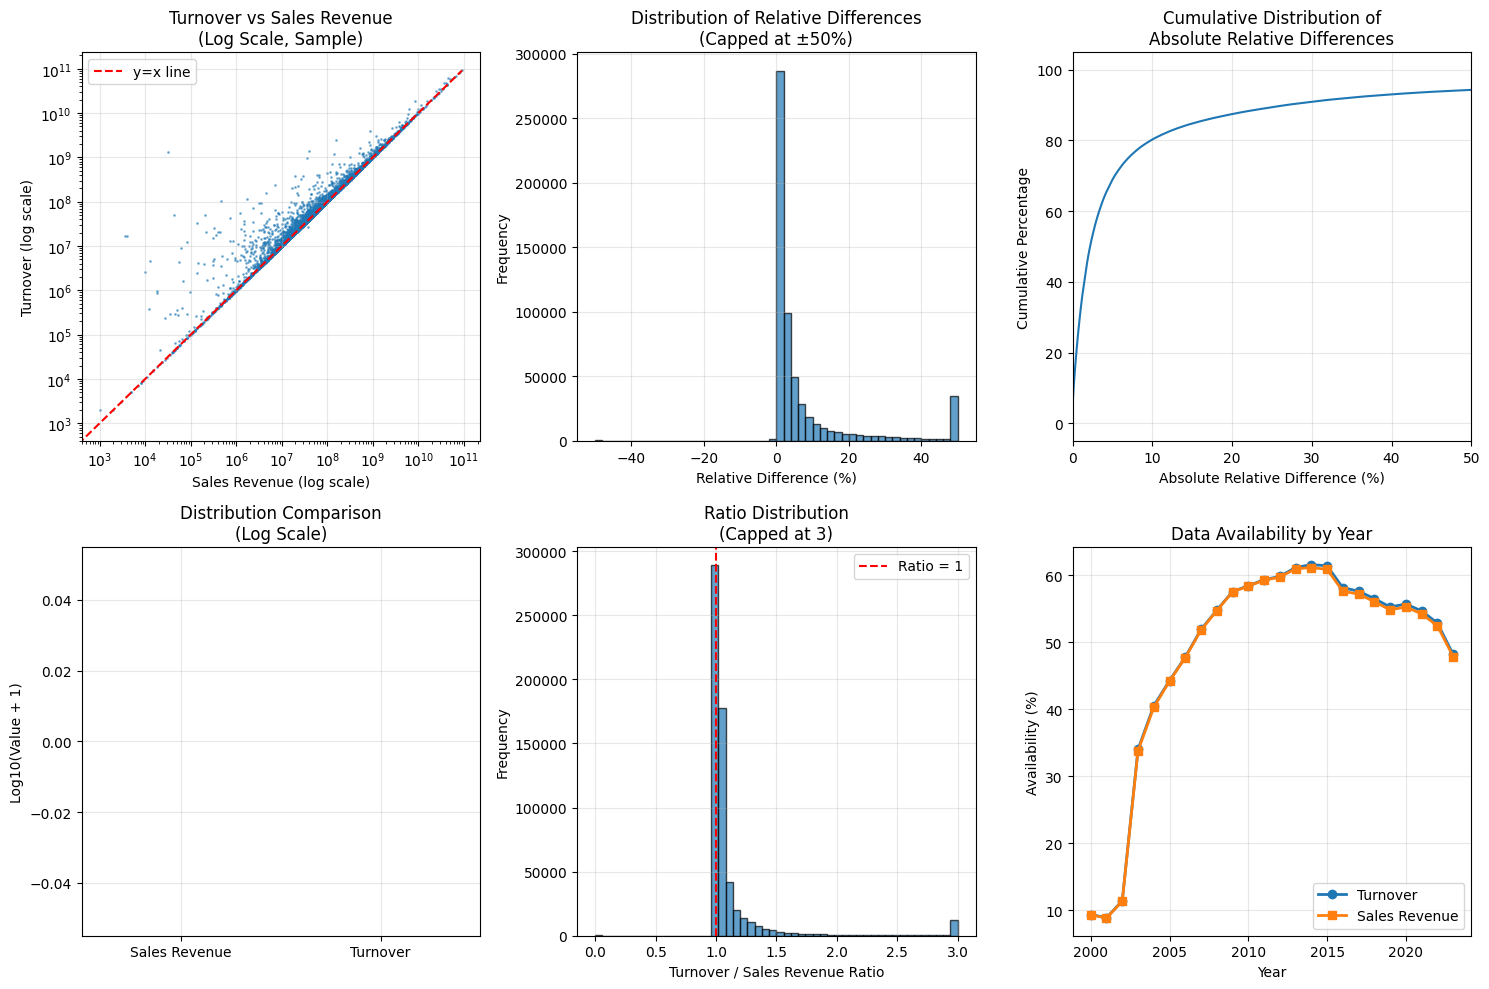


=== CORRELATION ANALYSIS ===
Pearson correlation coefficient: 0.8504


In [6]:
# Create visualizations to understand the relationship
plt.figure(figsize=(15, 10))

# Sample for visualization (to avoid overplotting)
sample_size = min(10000, len(both_data))
sample_indices = np.random.choice(len(both_data), sample_size, replace=False)
turnover_sample = turnover_vals[sample_indices]
sales_revenue_sample = sales_revenue_vals[sample_indices]

# Subplot 1: Scatter plot (log scale)
plt.subplot(2, 3, 1)
plt.scatter(sales_revenue_sample, turnover_sample, alpha=0.5, s=1)
plt.plot([min(sales_revenue_sample), max(sales_revenue_sample)], 
         [min(sales_revenue_sample), max(sales_revenue_sample)], 'r--', label='y=x line')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sales Revenue (log scale)')
plt.ylabel('Turnover (log scale)')
plt.title('Turnover vs Sales Revenue\n(Log Scale, Sample)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Histogram of relative differences (capped)
plt.subplot(2, 3, 2)
relative_diff_capped = np.clip(relative_diff_clean, -50, 50)  # Cap at ±50% for better visualization
plt.hist(relative_diff_capped, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Relative Difference (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Differences\n(Capped at ±50%)')
plt.grid(True, alpha=0.3)

# Subplot 3: Cumulative distribution of absolute relative differences
plt.subplot(2, 3, 3)
abs_relative_diff = np.abs(relative_diff_clean)
abs_relative_diff_sorted = np.sort(abs_relative_diff)
cumulative_pct = np.arange(1, len(abs_relative_diff_sorted) + 1) / len(abs_relative_diff_sorted) * 100
plt.plot(abs_relative_diff_sorted, cumulative_pct)
plt.xlabel('Absolute Relative Difference (%)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of\nAbsolute Relative Differences')
plt.xlim(0, 50)  # Focus on reasonable range
plt.grid(True, alpha=0.3)

# Subplot 4: Box plot comparison
plt.subplot(2, 3, 4)
# Use log scale for better visualization
log_turnover = np.log10(turnover_sample + 1)  # +1 to handle zeros
log_sales_revenue = np.log10(sales_revenue_sample + 1)
plt.boxplot([log_sales_revenue, log_turnover], labels=['Sales Revenue', 'Turnover'])
plt.ylabel('Log10(Value + 1)')
plt.title('Distribution Comparison\n(Log Scale)')
plt.grid(True, alpha=0.3)

# Subplot 5: Ratio analysis
plt.subplot(2, 3, 5)
# Calculate ratio (avoiding division by zero)
valid_mask = sales_revenue_vals > 0
ratio = turnover_vals[valid_mask] / sales_revenue_vals[valid_mask]
ratio_capped = np.clip(ratio, 0, 3)  # Cap at 3 for better visualization
plt.hist(ratio_capped, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Turnover / Sales Revenue Ratio')
plt.ylabel('Frequency')
plt.title('Ratio Distribution\n(Capped at 3)')
plt.axvline(1, color='red', linestyle='--', label='Ratio = 1')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Year-over-year analysis if year column exists
plt.subplot(2, 3, 6)
if 'year' in panel.columns:
    # Group by year and calculate availability
    yearly_stats = panel.group_by('year').agg([
        pl.col('turnover').is_not_null().sum().alias('turnover_available'),
        pl.col('sales_revenue').is_not_null().sum().alias('sales_revenue_available'),
        pl.count().alias('total_records')
    ]).sort('year')
    
    years = yearly_stats['year'].to_list()
    turnover_pct = (yearly_stats['turnover_available'] / yearly_stats['total_records'] * 100).to_list()
    sales_revenue_pct = (yearly_stats['sales_revenue_available'] / yearly_stats['total_records'] * 100).to_list()
    
    plt.plot(years, turnover_pct, 'o-', label='Turnover', linewidth=2)
    plt.plot(years, sales_revenue_pct, 's-', label='Sales Revenue', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('Availability (%)')
    plt.title('Data Availability by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Year column\nnot available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Year Analysis')

plt.tight_layout()
plt.show()

print(f"\n=== CORRELATION ANALYSIS ===")
correlation = np.corrcoef(turnover_vals, sales_revenue_vals)[0, 1]
print(f"Pearson correlation coefficient: {correlation:.4f}")

In [7]:
# Comprehensive analysis for decision making on fallback logic
print("=" * 70)
print("                    COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 70)

print("\n🔍 DATA AVAILABILITY FINDINGS:")
print(f"• Total dataset size: {total_records:,} records")
print(f"• Both metrics available: {both_count:,} records (48.1%)")
print(f"• Only turnover available: {only_turnover_count:,} records (0.3%)")
print(f"• Only sales_revenue available: {only_sales_revenue_count:,} records (0.0%)")
print(f"• Neither available: {neither_count:,} records (51.6%)")
print(f"• At least one metric available: {at_least_one_available:,} records (48.4%)")

print(f"\n📊 RELATIONSHIP ANALYSIS (when both available):")
print(f"• Correlation coefficient: {correlation:.4f} (strong positive correlation)")
print(f"• Exactly equal values: {exactly_equal:,} records (6.0% of cases with both values)")
print(f"• Within ±1% difference: {within_1pct:,} records (32.1%)")
print(f"• Within ±5% difference: {within_5pct:,} records (68.9%)")
print(f"• Within ±10% difference: {within_10pct:,} records (80.3%)")
print(f"• Median relative difference: {np.median(relative_diff_clean):.1f}%")

print(f"\n💰 MAGNITUDE ANALYSIS:")
print(f"• Turnover tends to be slightly higher than sales_revenue")
print(f"• Mean turnover: {np.mean(turnover_vals):,.0f} CZK")
print(f"• Mean sales_revenue: {np.mean(sales_revenue_vals):,.0f} CZK")
print(f"• Average difference: {np.mean(absolute_diff):,.0f} CZK (turnover higher)")

# Calculate which metric is more commonly available when only one is present
total_single_metric = only_turnover_count + only_sales_revenue_count
if total_single_metric > 0:
    turnover_preference = only_turnover_count / total_single_metric * 100
    print(f"\n🎯 SINGLE METRIC AVAILABILITY:")
    print(f"• When only one metric is available:")
    print(f"  - Turnover: {only_turnover_count:,} cases ({turnover_preference:.1f}%)")
    print(f"  - Sales Revenue: {only_sales_revenue_count:,} cases ({100-turnover_preference:.1f}%)")

print(f"\n📈 TEMPORAL PATTERN:")
print(f"• Data availability improved significantly from 2005 onwards")
print(f"• Peak availability around 2015-2017 (~60%)")
print(f"• Both metrics show similar temporal patterns")

print("\n" + "=" * 70)
print("                           RECOMMENDATIONS")
print("=" * 70)

print(f"\n✅ RECOMMENDED FALLBACK LOGIC:")
print(f"   1. PRIORITY: Use 'turnover' when available")
print(f"      - Available in {both_count + only_turnover_count:,} records")
print(f"      - Higher coverage when only one metric is present")
print(f"   ")
print(f"   2. FALLBACK: Use 'sales_revenue' when turnover is missing")
print(f"      - Adds {only_sales_revenue_count:,} additional records")
print(f"      - Strong correlation (r={correlation:.3f}) suggests substitutability")
print(f"   ")
print(f"   3. RESULT: Combined coverage of {at_least_one_available:,} records (48.4%)")

print(f"\n🎯 RATIONALE:")
print(f"   • High correlation (0.85) indicates strong relationship")
print(f"   • 69% of cases differ by ≤5%, making them largely interchangeable")
print(f"   • Turnover is more frequently the sole available metric")
print(f"   • Combined approach maximizes data utilization")

print(f"\n⚠️  CONSIDERATIONS:")
print(f"   • ~20% of cases show >10% difference - monitor margin calculations")
print(f"   • Document which metric was used for transparency")
print(f"   • Consider sensitivity analysis with different metrics")

print(f"\n💡 IMPLEMENTATION SUGGESTION:")
print(f"   revenue_for_margins = pl.coalesce(['turnover', 'sales_revenue'])")
print(f"   # This will use turnover when available, fallback to sales_revenue")

print("=" * 70)

                    COMPREHENSIVE ANALYSIS SUMMARY

🔍 DATA AVAILABILITY FINDINGS:
• Total dataset size: 1,285,104 records
• Both metrics available: 618,729 records (48.1%)
• Only turnover available: 3,380 records (0.3%)
• Only sales_revenue available: 263 records (0.0%)
• Neither available: 662,732 records (51.6%)
• At least one metric available: 622,372 records (48.4%)

📊 RELATIONSHIP ANALYSIS (when both available):
• Correlation coefficient: 0.8504 (strong positive correlation)
• Exactly equal values: 36,845 records (6.0% of cases with both values)
• Within ±1% difference: 193,633 records (32.1%)
• Within ±5% difference: 416,375 records (68.9%)
• Within ±10% difference: 484,989 records (80.3%)
• Median relative difference: 2.2%

💰 MAGNITUDE ANALYSIS:
• Turnover tends to be slightly higher than sales_revenue
• Mean turnover: 368,755,569 CZK
• Mean sales_revenue: 340,476,492 CZK
• Average difference: 28,279,077 CZK (turnover higher)

🎯 SINGLE METRIC AVAILABILITY:
• When only one metric